#計算機程式設計二
#第六週上課內容

## 主題：分析 Binary Expression 以及建構 Syntax Tree


#### 這份教材主要是解釋與 mini project 相關的 parsing 和 syntax tree 概念。

###GitHub 教材參考資料

[i2p-nthu 程式設計二 Syntax Trees](https://github.com/htchen/i2p-nthu/blob/master/%E7%A8%8B%E5%BC%8F%E8%A8%AD%E8%A8%88%E4%BA%8C/mid1/5-syntax_tree.md)





####Expression 運算

像`4*x + 5*y`這樣的的運算式 (expression)，該如何用程式來分析並且計算？首先要先把每個元素拆開來，包含了數值 `4`和`5`、運算符號`*`和`+`、以及變數`x`和`y`。而這些元素如果依照數學運算的原則，應該要先算`4*x`以及`5*y`，然後再把兩個運算結果加起來。假設變數`x`的值是`1`而`y`是`2`，代入之後得到的運算結果就是`14`。

先記住這件事：每個 expression ，最終都可以得到一個數值。
即使包含變數，當變數用對應的值代入之後，最後就會算出某個值。上面的運算式，可以拆解成三個運算式：兩個乘法運算和一個加法運算，其中加法運算是基於兩個乘法運算的結果。

上面出現的運算符號`*`和`+`所牽涉到的運算，都是二元運算 (binary operation)，每次運算都需要兩個運算元 (operands)。運算的時候，必須依照運算符號的優先順序，例如先乘除後加減，而且通常是從左到右依序運算。如果想要違背優先順序的運算，通常會另外使用括號來界定順序。

但是，假如我們不要把運算符號寫在中間，而是寫在最前面 (prefix notation)，像是 `* 4 x`，這樣的寫法，不需要括號，也能表達出各種可能的運算順序。以上面的運算式為例，原本的運算可以寫成

	+ * 4 x * 5 y

首先看到 `+` 所以預期後面應該要有兩個可以"加"的東西，可能是數值或是變數。接下來看到`*`，是個運算符號，不是能夠拿來"加"的東西，所以還不能被當作前面`+`符號的運算元，還必須繼續看下去。再來看到`4`，然後又看到`x`，所以`*`所需的兩個運算元就具備了，就可以得到`(* 4 x)`這個運算式，這個運算式最終應該會得到某個值，所以可以拿來當作運算元，如此一來，前面的`+`所需的兩個運算元就具備了其中之一。接下來，`* 5 y`也構成了另一個運算式，因此`+`所需的第二個運算元也具備了，整個運算式就分析完成。

現在換成另一種狀況，假如我們想要的運算其實是`4 * (x + 5) * y`，如果用 prefix notation 來表達，依然不需要括號就能寫出來，只要寫成下面的形式就行了：

	* * 4 + x 5 y

運算的順序會是`+ x 5`，把運算結果另外取個名字叫做`E1` 然後是`* 4 E1`，再把這個運算結果取名`E2`，然後就可以算`* E2 y`，算完就得到最後的結果，符合原本想要的`4 * (x + 5) * y`。

問題：如何寫程式分析 prefix expression？   

In [ ]:
%%writefile E06_01.c
#include <stdio.h>
#include <string.h>
#include <stdlib.h>
#include <ctype.h>

#define MAXEXPR 256
char expr[MAXEXPR];

typedef enum {VAR_A, VAR_B, VAR_C, VAR_D, OP_AND, OP_OR, END} TokenSet;

char sym[]="ABCD&|";

TokenSet getNext(int reset)
{
    static int idx;
    TokenSet ret = END;
    int i;

    if (reset) {
        idx = 0;
        return END;
    }

    while (expr[idx]!='\0' && isspace(expr[idx])) idx++;

    if (expr[idx] == '\0') {
        return END;
    } else {
        for (i=0; (size_t)i<strlen(sym)-1; i++) {
            if (sym[i]==expr[idx]) ret = i;
        }
        idx++;
        return ret;
    }
}

/* an expression can be evaluated and yield an integer value */
int evaluate(int A, int B, int C, int D)
{
    TokenSet tok;
    int ev1, ev2;

    tok = getNext(0); // not reset
    switch (tok) {
      case VAR_A:
        return A;
      case VAR_B:
        return B;
      case VAR_C:
        return C;
      case VAR_D:
        return D;
      case OP_AND:
        ev1 = evaluate(A, B, C, D);
        ev2 = evaluate(A, B, C, D);
        return ev1 && ev2;
      case OP_OR:
        ev1 = evaluate(A, B, C, D);
        ev2 = evaluate(A, B, C, D);
        return ev1 || ev2;
      case END:
        tok = getNext(1);
        return evaluate(A, B, C, D);
    }
    return 0;
}

int main()
{
    size_t len;
    int i;

    fgets(expr, sizeof(expr), stdin);

    len = strlen(expr);
    if (len > 0 && expr[len-1] == '\n') {
        --len;
       expr[len] = '\0';
    }
    printf("%s\n", expr);

    for (i=0; i<16; i++) {
        printf("%d%d%d%d: %d\n", (i&8)>>3, (i&4)>>2, (i&2)>>1, i&1,
          evaluate((i&8)>>3,(i&4)>>2,(i&2)>>1, i&1));
    }

    return 0;
}

Overwriting E06_01.c


In [ ]:
%%shell
gcc -o E06_01 E06_01.c
./E06_01

& | A B | C D
& | A B | C D

0000: 0
0001: 0
0010: 0
0011: 0
0100: 0
0101: 1
0110: 1
0111: 1
1000: 0
1001: 1
1010: 1
1011: 1
1100: 0
1101: 1
1110: 1
1111: 1


####用 Boolean Expression 來練習

整數運算還是稍嫌複雜，我們再更簡化一點，先從 Boolean expression 開始處理。假設只有兩種 Boolean operation，`&`和`|`，分別計算 AND 和 OR，另外也規定只有四個 Boolean 變數，`A` `B` `C` `D`，每個變數的值只會是`0`或`1`，例如  

	| & A B & C D

底下是完整的範例程式碼，我們會再一一解釋每個函數的作用。
範例中有特別處理輸入資料裡面參雜的空白字元，如果假定輸入資料全部都相連不會有空白，程式碼可以再簡化一些。

```c
#include <stdio.h>
#include <string.h>
#include <stdlib.h>
#include <ctype.h>

#define MAXEXPR 256
char expr[MAXEXPR];

typedef enum {VAR_A, VAR_B, VAR_C, VAR_D, OP_AND, OP_OR, END} TokenSet;
char sym[]="ABCD&|";

TokenSet getNext(int reset)
{
    static int idx;
    TokenSet ret = END;
    int i;

    if (reset) {
        idx = 0;
        return END;
    }

    while (expr[idx]!='\0' && isspace(expr[idx])) idx++;

    if (expr[idx] == '\0') {
        return END;
    } else {
        for (i=0; (size_t)i<strlen(sym); i++) {
            if (sym[i]==expr[idx]) ret = i;
        }
        idx++;
        return ret;
    }
}

int evaluate(int A, int B, int C, int D)
{
    TokenSet tok;
    tok = getNext(0);
    if (tok==END) {
        tok = getNext(1);
        return evaluate(A, B, C, D);
    } else if (tok==OP_AND || tok==OP_OR) {
        int expr1, expr2;
        expr1 = evaluate(A, B, C, D);
        expr2 = evaluate(A, B, C, D);
        if (tok==OP_AND) {
            return (expr1 && expr2);
        }  else {
            return (expr1 || expr2);
        }
    } else {
        switch (tok) {
            case VAR_A: return A;
            case VAR_B: return B;
            case VAR_C: return C;
            case VAR_D: return D;
            default: return -1;
        }
    }
}

int main()
{
    size_t len;
    int i;

    fgets(expr, sizeof(expr), stdin);
    len = strlen(expr);
    if (len > 0 && expr[len-1] == '\n') {
        --len;
        expr[len] = '\0';
    }

    for (i=0; i<16; i++) {
        printf("%d%d%d%d: %d\n", (i&8)>>3, (i&4)>>2, (i&2)>>1, i&1,
        evaluate((i&8)>>3,(i&4)>>2,(i&2)>>1, i&1));
    }

    return 0;
}
```


####用 Boolean Expression 來練習

整數運算還是稍嫌複雜，我們再更簡化一點，先從 Boolean expression 開始處理。假設只有兩種 Boolean operation，`&`和`|`，分別計算 AND 和 OR，另外也規定只有四個 Boolean 變數，`A` `B` `C` `D`，每個變數的值只會是`0`或`1`，例如  

	| & A B & C D

底下是完整的範例程式碼，我們會再一一解釋每個函數的作用。
範例中有特別處理輸入資料裡面參雜的空白字元，如果假定輸入資料全部都相連不會有空白，程式碼可以再簡化一些。

```c
#include <stdio.h>
#include <string.h>
#include <stdlib.h>
#include <ctype.h>

#define MAXEXPR 256
char expr[MAXEXPR];

typedef enum {VAR_A, VAR_B, VAR_C, VAR_D, OP_AND, OP_OR, END} TokenSet;
char sym[]="ABCD&|";

TokenSet getNext(int reset)
{
    static int idx;
    TokenSet ret = END;
    int i;

    if (reset) {
        idx = 0;
        return END;
    }

    while (expr[idx]!='\0' && isspace(expr[idx])) idx++;

    if (expr[idx] == '\0') {
        return END;
    } else {
        for (i=0; (size_t)i<strlen(sym); i++) {
            if (sym[i]==expr[idx]) ret = i;
        }
        idx++;
        return ret;
    }
}

int evaluate(int A, int B, int C, int D)
{
    TokenSet tok;
    tok = getNext(0);
    if (tok==END) {
        tok = getNext(1);
        return evaluate(A, B, C, D);
    } else if (tok==OP_AND || tok==OP_OR) {
        int expr1, expr2;
        expr1 = evaluate(A, B, C, D);
        expr2 = evaluate(A, B, C, D);
        if (tok==OP_AND) {
            return (expr1 && expr2);
        }  else {
            return (expr1 || expr2);
        }
    } else {
        switch (tok) {
            case VAR_A: return A;
            case VAR_B: return B;
            case VAR_C: return C;
            case VAR_D: return D;
            default: return -1;
        }
    }
}

int main()
{
    size_t len;
    int i;

    fgets(expr, sizeof(expr), stdin);
    len = strlen(expr);
    if (len > 0 && expr[len-1] == '\n') {
        --len;
        expr[len] = '\0';
    }

    for (i=0; i<16; i++) {
        printf("%d%d%d%d: %d\n", (i&8)>>3, (i&4)>>2, (i&2)>>1, i&1,
        evaluate((i&8)>>3,(i&4)>>2,(i&2)>>1, i&1));
    }

    return 0;
}
```

首先，我們用 `enum` 和 `typedef` 自定了 `TokenSet`。其中包含的 `VAR_A` `VAR_B` `OP_AND` 這些都是對應到整數值，`VAR_A`的值是`0`、`VAR_B`是`1`、`OP_AND`是`4`，‧‧‧ 。這樣的寫法是為了方便我們之後在做各種條件判斷的時候，不必直接用整數值，而是可以用看起來比較有意義的名稱，`VAR_A` 代表變數 `A`， `OP_AND`代表運算符號`&`。

再來看 `main` 裡面做了哪些事情。一開始是用 `fgets`讀取整行輸入資料，
`fgets`的用法請參考

<http://pubs.opengroup.org/onlinepubs/9699919799/functions/fgets.html>

讀取到的資料放在 `expr` 陣列中，`expr` 陣列是 `global`，全部的函數都看得到它。

之後的`for`迴圈，則是用二進位表示法，跑完`A` `B` `C` `D`四個變數，`0`或`1`兩種可能的值，全部16種組合(2的4次方)。關於位元運算，可以複習「計算機程式設計一」的教材。

In [ ]:
%%writefile E06_01.c
#include <stdio.h>
#include <stdlib.h>


In [ ]:
%%shell
gcc -o E06_01 E06_01.c
./E06_01

#####函數`getNext`
自己寫的`getNext`函數，目的是為了找到下一個非空白的字元，並且判斷出是哪個 token，然後把對應的 token 代號傳回去。
函數中的 `static` 變數 `idx`，是用來記住目前讀取到`expr`陣列的哪個位置。

#####函數`evaluate`
這是整個程式中最關鍵的函數。用遞迴方式來算出 prefix 表示法之下，Boolean expression 帶入變數值之後，得到的運算結果。
依照目前讀取到的 token，決定要做哪些事情。
1. 如果 token 是變數，就把當時的變數值傳回去。
2. 如果 token 是運算符號`&` 或 `|`，就先把後面應該要有的兩個運算元，分別透過遞迴算出來
           expr1 = evaluate(A, B, C, D);
           expr2 = evaluate(A, B, C, D);

    然後再做對應的組合及運算

    ```c
        if (tok==OP_AND) {
            return (expr1 && expr2);
        }  else {
            return (expr1 || expr2);
        }
    ```

上面用 `&&` 和 `||` 條件判斷來當作邏輯運算，是因為C的 True 通常會用整數`1`來表示， False 會用整數`0`表示，恰好符合我們想要的 boolean 運算結果。

####處理十進位 + - * / 運算，從 prefix 轉 infix
底下是「計算機程式設計一」教到 recusion 時，介紹過的範例。把輸入的 prefix 整數運算，轉成 infix 並且算出最後的答案。

```c
#include <stdio.h>
#include <ctype.h>

int calculate(void);

int main(void)
{
    printf("=%d\n", calculate());
    return 0;
}

int calculate(void)
{
    int c;
    int ans;
    int op1, op2;

    c = getchar();
    if (isspace(c)) {
        ans = calculate();
    } else if (c=='+') {
        printf("(");
        op1 = calculate();
        printf("+");
        op2 = calculate();
        printf(")");
        ans = op1 + op2;
    } else if (c=='-') {
        printf("(");
        op1 = calculate();
        printf("-");
        op2 = calculate();
        printf(")");
        ans = op1 - op2;
    } else if (c=='*') {
        printf("(");
        op1 = calculate();
        printf("*");
        op2 = calculate();
        printf(")");
        ans = op1 * op2;
    } else if (isdigit(c)) {
        ungetc(c, stdin);
        scanf("%d", &ans);
        printf("%d", ans);
    }

    return ans;

}
```


In [ ]:
%%writefile E06_02.c
# include <stdio.h>
# include <ctype.h>

int calculate(void);

int main(void)
{
    printf("=%d\n", calculate());
    return 0;
}

int calculate(void)
{
    int c;
    int ans;
    int op1, op2;

    c = getchar();
    if (isspace(c)) {
        ans = calculate();
    } else if (c=='+') {
        printf("(");
        op1 = calculate();
        printf("+");
        op2 = calculate();
        printf(")");
        ans = op1 + op2;
    } else if (c=='-') {
        printf("(");
        op1 = calculate();
        printf("-");
        op2 = calculate();
        printf(")");
        ans = op1 - op2;
    } else if (c=='*') {
        printf("(");
        op1 = calculate();
        printf("*");
        op2 = calculate();
        printf(")");
        ans = op1 * op2;
    } else if (isdigit(c)) {
        ungetc(c, stdin);
        scanf("%d", &ans);
        printf("%d", ans);
    }

    return ans;

}

Writing E06_02.c


In [ ]:
%%shell
gcc -o E06_02 E06_02.c
./E06_02

* * 4 + 100 5 200
((4*(100+5))*200)=84000


####建立 Syntax Tree

底下的圖，是大家在邏輯設計課裡面會看到的邏輯閘。

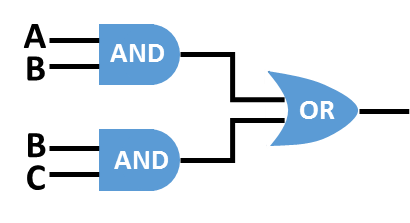


下圖則是 syntax tree 示意圖，可以看得出結構和上面的邏輯閘圖很相似。

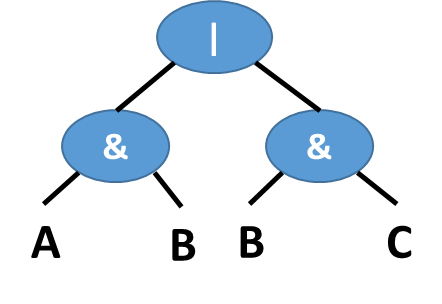

In [ ]:
      A   |    ( A B & C )

     EXPR OP    FACTOR


            B      &      C
            EXPR   OP    FACTOR
                  EXPR

In [ ]:
# include <stdio.h>
# include <string.h>
# include <stdlib.h>
# include <ctype.h>

# define MAXEXPR 256

char expr[MAXEXPR];
int pos;

typedef enum {VAR_A, VAR_B, VAR_C, VAR_D, OP_AND, OP_OR, END
             } TokenSet;
char sym[]="ABCD&|()";

typedef struct _Node {
    TokenSet data;
    struct _Node *left, *right;
} BTNode;

BTNode* EXPR();
BTNode* FACTOR();

/* create a node without any child.*/
BTNode* makeNode(char c){
    int i;
    BTNode *node = (BTNode*) malloc(sizeof(BTNode));
    for (i = 0; (unsigned int)i < strlen(sym); i++)
        if (c==sym[i]) node->data = i;
    node->left = NULL;
    node->right = NULL;
    return node;
}

/* clean a tree.*/
void freeTree(BTNode *root){
    if (root!=NULL) {
        freeTree(root->left);
        freeTree(root->right);
        free(root);
    }
}

/* print a tree by pre-order. */
void printPrefix(BTNode *root){
    if (root != NULL) {
        printf("%c",sym[root->data]);
        printPrefix(root->left);
        printPrefix(root->right);
    }
}

/* FACTOR = VAR | (EXPR) */
BTNode* FACTOR(){
    char c;
    BTNode *node = NULL;

    if (pos>=0) {
        c = expr[pos--];
        if (c>= 'A' && c<='D'){ // apply the rule FACTOR = VAR
            // make a new node for VAR
            node = makeNode(c);
        } else if (c==')') {  // apply the rule FACTOR = (EXPR)
            // get the node pointer from recusive call of EXPR()
            node = EXPR();
            if(expr[pos--]!= '(') {  // the left parenthesis is needed
                printf("Error: not matching parenthesis!\n");
                freeTree(node);
            }
        }
    }
    return node;
}

/* parse an infix expression and generate a syntax tree.
 EXPR = FACTOR| EXPR OP FACTOR */
BTNode* EXPR(){
    char c;
    BTNode *node = NULL, *right=NULL;

    if (pos>=0) {   // if the expression has length > 1.
        // get the pointer to the right child from calling the function FACTOR()
        right = FACTOR();
        if (pos>0) {
            c = expr[pos];
            if (c=='&' || c=='|'){  // apply the rule EXPR = EXPR OP FACTOR
                // make a new node for the OP
                node = makeNode(c);
                // set the node's right child as ...
                node->right = right;
                pos--; // this step is important

                // set the node's left child from recursive call of EXPR()
                node->left = EXPR();
            } else node = right; // apply the rule EXPR = FACTOR
        } else
            node = right; // apply the rule EXPR = FACTOR
    }
    return node;
}

int main(void)
{
      size_t len;
    fgets(expr, sizeof(expr), stdin);
    len = strlen(expr);
    if (len > 0 && expr[len-1] == '\n') {
        --len;
        expr[len] = '\0';
    }
    pos = strlen(expr) - 1;
    BTNode *root = EXPR();
    printPrefix(root);
    freeTree(root);
    return 0;
}



之後會讓大家試著寫程式，將 infix 輸入的 Boolean expression，轉換成 syntax tree。
######*注意*：我們假設輸入的 Boolean expression 不包含空白字元，讓問題單純一點，把重點放在如何分析語法。


#####Left Association
忽略`&` 和 `|` 的符號運算優先順序，只考慮出現的位置。
Left association 的意思是，`A|B&C` 要解讀成 `(A|B)&C`，而不要當作 `A|(B&C)`。

考慮底下的語法規則

	EXPR = FACTOR | EXPR OP FACTOR
	FACTOR = VAR | (EXPR)

意思是 expression `EXPR` 可以有兩種，一種由 `FACTOR` 構成，而另一種是可以繼續遞迴展開，`EXPR OP FACTOR`。
而 `FACTOR` 則是定成 `VAR` 也就是單一變數就可以被視為是一個`FACTOR`，另外一種情況則是 被左右括號框住的 `EXPR`，而`EXPR`根據第一個語法，又可以再繼續展開。



李哲榮老師提供的演算法如下：

	Parsing EXPR = FACTOR | EXPR OP FACTOR
	1. Find a factor from the end of expression
	2. If there is an OP in front of the factor
	 	2.1 Let factor be OP’s right child     
	 	2.2 Parse the remaining expression recursively and make it OP’s left child


底下是依據上面的演算法寫成的範例，函數空缺的部分，請大家補上 `???` 的程式碼

```c
#include <stdio.h>
#include <string.h>
#include <stdlib.h>
#include <ctype.h>

#define MAXEXPR 256

char expr[MAXEXPR];
int pos;

typedef enum {VAR_A, VAR_B, VAR_C, VAR_D, OP_AND, OP_OR, END
             } TokenSet;
char sym[]="ABCD&|()";

typedef struct _Node {
    TokenSet data;
    struct _Node *left, *right;
} BTNode;

BTNode* EXPR();
BTNode* FACTOR();

/* create a node without any child.*/
BTNode* makeNode(char c){
    int i;
    BTNode *node = (BTNode*) malloc(sizeof(BTNode));
    for (i = 0; (unsigned int)i < strlen(sym); i++)
        if (c==sym[i]) node->data = i;
    node->left = NULL;
    node->right = NULL;
    return node;
}

/* clean a tree.*/
void freeTree(BTNode *root){
    if (root!=NULL) {
        freeTree(root->left);
        freeTree(root->right);
        free(root);
    }
}

/* print a tree by pre-order. */
void printPrefix(BTNode *root){
    if (root != NULL) {
        printf("%c",sym[root->data]);
        printPrefix(root->left);
        printPrefix(root->right);
    }
}

/* FACTOR = VAR | (EXPR) */
BTNode* FACTOR(){
    char c;
    BTNode *node = NULL;

    if (pos>=0) {
        c = expr[pos--];
        if (c>= 'A' && c<='D'){ // apply the rule FACTOR = VAR
            // make a new node for VAR
            ???
        } else if (c==')') {  // apply the rule FACTOR = (EXPR)
            // get the node pointer from recusive call of EXPR()
            ???
            if(expr[pos--]!= '(') {  // the left parenthesis is needed
                printf("Error: not matching parenthesis!\n");
                freeTree(node);
            }
        }
    }
    return node;
}
```


```c
/* parse an infix expression and generate a syntax tree.
 EXPR = FACTOR| EXPR OP FACTOR */
BTNode* EXPR(){
    char c;
    BTNode *node = NULL, *right=NULL;

    if (pos>=0) {   // if the expression has length > 1.
        // get the pointer to the right child from calling the function FACTOR()         
        right = ???
        if (pos>0) {
            c = expr[pos];
            if (c=='&' || c=='|'){  // apply the rule EXPR = EXPR OP FACTOR
                // make a new node for the OP
                node = ???
                // set the node's right child as ...
                node->right = ???                    
                pos--; // this step is important
                
                // set the node's left child from recursive call of EXPR()
                node->left = ???
            } else node = right; // apply the rule EXPR = FACTOR
        } else
            node = right; // apply the rule EXPR = FACTOR
    }
    return node;
}

int main(void)
{
	  size_t len;
    fgets(expr, sizeof(expr), stdin);
    len = strlen(expr);
    if (len > 0 && expr[len-1] == '\n') {
        --len;
        expr[len] = '\0';
    }
    pos = strlen(expr) - 1;
    BTNode *root = EXPR();
    printPrefix(root);
    freeTree(root);
    return 0;
}
```


In [ ]:
%%writefile E06_02.c
# include <stdio.h>
# include <string.h>
# include <stdlib.h>
# include <ctype.h>

# define MAXEXPR 256

char expr[MAXEXPR];
int pos;

typedef enum {VAR_A, VAR_B, VAR_C, VAR_D, OP_AND, OP_OR, END
             } TokenSet;
char sym[]="ABCD&|()";

typedef struct _Node {
    TokenSet data;
    struct _Node *left, *right;
} BTNode;

BTNode* EXPR();
BTNode* FACTOR();

/* create a node without any child.*/
BTNode* makeNode(char c){
    int i;
    BTNode *node = (BTNode*) malloc(sizeof(BTNode));
    for (i = 0; (unsigned int)i < strlen(sym); i++)
        if (c==sym[i]) node->data = i;
    node->left = NULL;
    node->right = NULL;
    return node;
}

/* clean a tree.*/
void freeTree(BTNode *root){
    if (root!=NULL) {
        freeTree(root->left);
        freeTree(root->right);
        free(root);
    }
}

/* print a tree by pre-order. */
void printPrefix(BTNode *root){
    if (root != NULL) {
        printf("%c",sym[root->data]);
        printPrefix(root->left);
        printPrefix(root->right);
    }
}

/* print a tree by pre-order. */
int evalPrefix(BTNode *root, int A, int B, int C, int D)
{
    int ev1, ev2;
    if (root != NULL) {
        printf("%c",sym[root->data]);
        if (root->data == OP_AND) {
            ev1 = evalPrefix(root->left, A, B, C, D);
            ev2 = evalPrefix(root->right, A, B, C, D);
            return ev1 && ev2;
        } else if (root->data == OP_OR) {
            ev1 = evalPrefix(root->left, A, B, C, D);
            ev2 = evalPrefix(root->right, A, B, C, D);
            return ev1 || ev2;
        } else {
           switch (root->data) {
            case VAR_A:
              return A;
            case VAR_B:
              return B;
            case VAR_C:
              return C;
            case VAR_D:
              return D;
           }
        }
    }
}

/* FACTOR = VAR | (EXPR) */
BTNode* FACTOR(){
    char c;
    BTNode *node = NULL;

    if (pos>=0) {
        c = expr[pos--];
        if (c>= 'A' && c<='D'){ // apply the rule FACTOR = VAR
            // make a new node for VAR
            node = makeNode(c);
        } else if (c==')') {  // apply the rule FACTOR = (EXPR)
            // get the node pointer from recusive call of EXPR()
            node = EXPR();
            if(expr[pos--]!= '(') {  // the left parenthesis is needed
                printf("Error: not matching parenthesis!\n");
                freeTree(node);
            }
        }
    }
    return node;
}
/* parse an infix expression and generate a syntax tree.
 EXPR = FACTOR| EXPR OP FACTOR */
BTNode* EXPR() {
    char c;
    BTNode *node = NULL, *right=NULL;

    if (pos>=0) {   // if the expression has length > 1.
        // get the pointer to the right child from calling the function FACTOR()
        right = FACTOR();
        if (pos>0) {
            c = expr[pos];
            if (c=='&' || c=='|'){  // apply the rule EXPR = EXPR OP FACTOR
                // make a new node for the OP
                node = makeNode(c);
                // set the node's right child as ...
                node->right = right;
                pos--; // this step is important

                // set the node's left child from recursive call of EXPR()
                node->left = EXPR();
            } else node = right; // apply the rule EXPR = FACTOR
        } else
            node = right; // apply the rule EXPR = FACTOR
    }
    return node;
}

int main(void)
{
      size_t len;
    fgets(expr, sizeof(expr), stdin);
    len = strlen(expr);
    if (len > 0 && expr[len-1] == '\n') {
        --len;
        expr[len] = '\0';
    }
    pos = strlen(expr) - 1;
    BTNode *root = EXPR();
    printPrefix(root);

    printf("%d\n", evalPrefix(root, 0, 1, 1, 1));
    freeTree(root);
    return 0;
}

Overwriting E06_02.c


In [ ]:
%%shell
gcc -o E06_02 E06_02.c
./E06_02

A|(B&C)
|A&BC|A&BC1


以`A|(B&C)`為例，分析之後得到的語法示意圖如下：



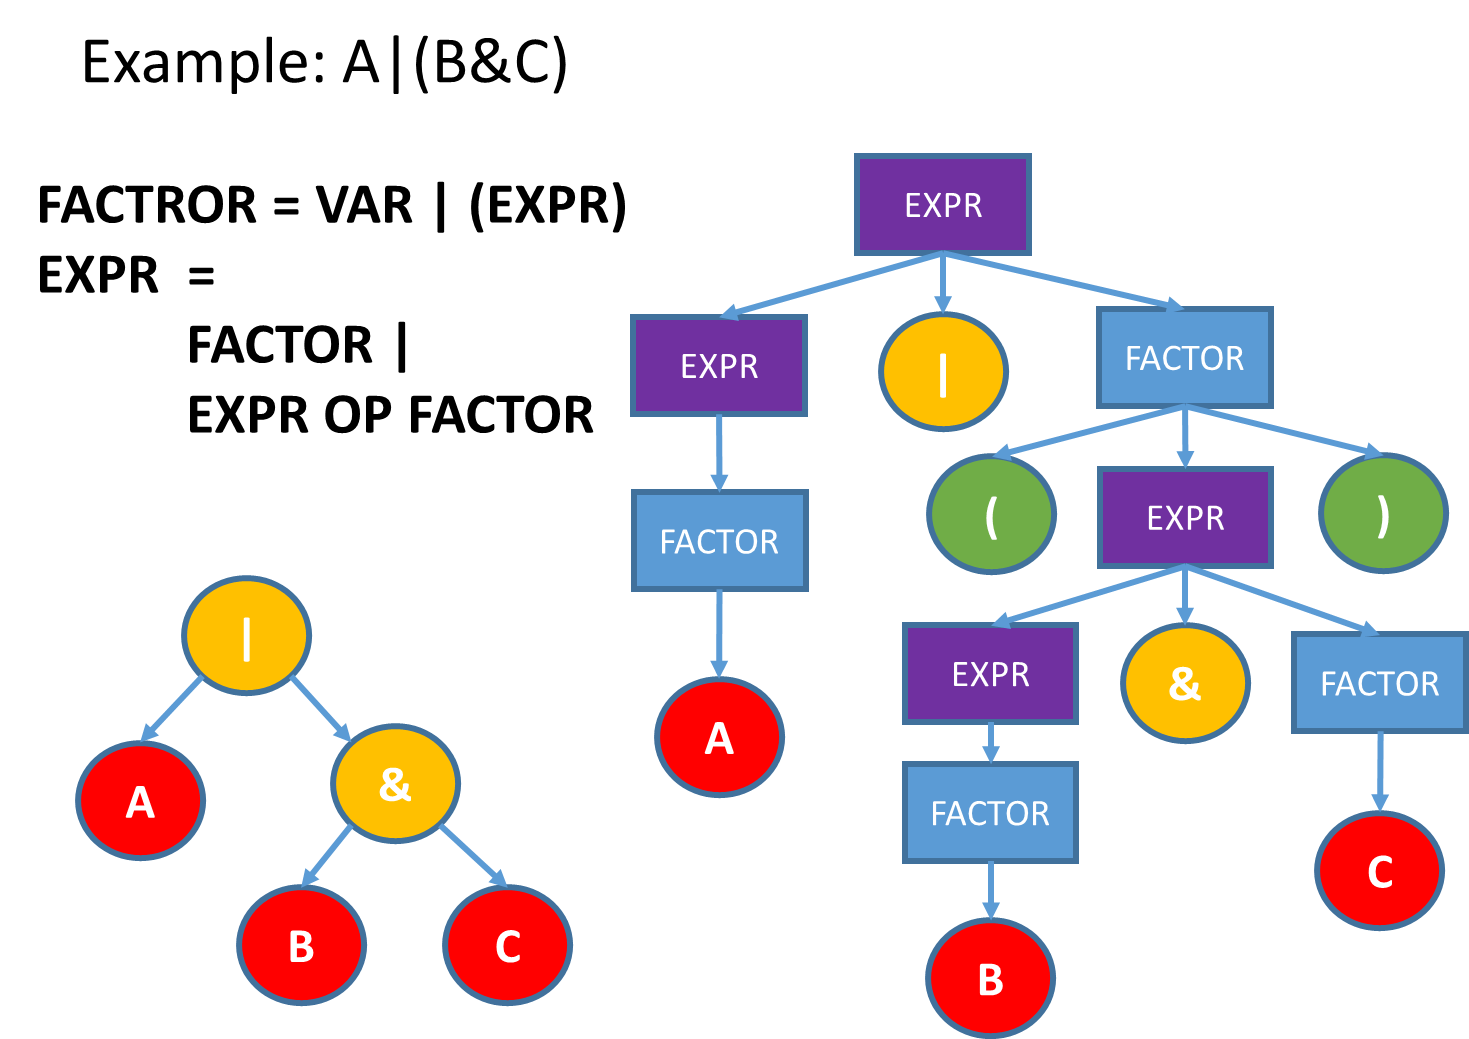